# Matrix Factorization with Expander Graphs

## Supporting Functions

### Functions for generating and checking data

In [67]:
# IMPORTS
import numpy as np
import copy
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from numpy import linalg as LA


# DATA GENERATION AND PERFORMANCE CHECKING FUNCTIONS
def generate_latent(n,k,c1,c2):
    b = c2-c1
    a = c1/b
    x = np.zeros(n)
    locs = np.random.permutation(n)[:k]
    x[locs] = 1
    signs = np.sign(np.random.randn(k))
    vals = b*(np.random.rand(k)+a)
    x[locs] = x[locs]*vals*signs
    return x

def generate_exp_dictionary1(m,n,d):
    A = np.zeros((m,n))
    for i in range(n):
        locs = np.random.permutation(m)[:d]
        A[locs,i] = 1
    return A

def generate_exp_dictionary2(m,n,d):
    A = np.zeros((m,n))
    alpha = int(np.floor(m/d))
    c = 0
    while c<n:
        perm = np.random.permutation(m)
        zeta = min(n-c, alpha)
        for j in range(zeta):
            locs = perm[j*d:(j+1)*d]
            A[locs,c] = 1
            c = c+1
    return A

def check_dictionary(eps,n,d,A):
    t = (1-4*eps)*d
    mu_A = np.max(np.transpose(A)@A - d*np.identity(n))
    if mu_A >= t:
        print("Generation error, A is not expander for this value of epsilon, mu_A = ", str.format('{0:.2f}', mu_A),", tau = ", str.format('{0:.2f}', t), ".")
        passed = False
    else:
        print("A passes coherence test, mu_A = ", str.format('{0:.2f}', mu_A),", tau = ", str.format('{0:.2f}', t), ".")
        passed = True
    return passed  
        
def check_recon_A(A,A_rec,d,eps,n):
    print("Checking reconstruction of A.")
    col_sum = sum(A_rec)
    print(str.format('{0:.1f}',100*len(col_sum[col_sum==d])/n), "% of columns fully formed.")
    print(str.format('{0:.1f}',100*(n - len(col_sum[col_sum==d]) - len(col_sum[col_sum==0]))/n) , "% of columns partially formed.")
    print(str.format('{0:.1f}', 100*len(col_sum[col_sum==0])/n), "% of columns have no entries.")
    overlaps = np.transpose(A_rec)@A
    A_rec_col, A_col = np.where(overlaps>(1-4*eps)*d)
    if len(col_sum[col_sum==0])<n:
        print(str.format('{0:.1f}', 100*len(A_rec_col)/(n - len(col_sum[col_sum==0]))), "% of reconstructed (fully or partially) columns match with a column in target matrix.")  
    error = 0
    missing = 0
    P = np.zeros((n,n))
    for i in range(len(A_rec_col)):
        diff = A_rec[:, A_rec_col[i]] - A[:,A_col[i]]
        error = error + sum(abs(diff[diff==1]))
        missing = missing + sum(abs(diff[diff==-1]))
        P[A_col[i], A_rec_col[i]] = 1
    print(str.format('{0:.0f}', 100*(missing+d*n-len(A_rec_col)*d)/(d*n)), "% of entries missing in total.")
    print(str.format('{0:.0f}', missing), "entries missing in matched columns.")
    print(str.format('{0:.0f}', error), "entries wrong in matched columns.")
    return P
    
def check_recon_X(X,X_rec,P,N,k,n):
    X_perm = P@X_rec
    print("Checking the values of X recovered.")
    tol = 10**-6
    total_entries = N*k
    total_entries_recovered = 0
    correct_loc_correct_val = 0
    correct_loc_wrong_val = 0
    wrong_loc = 0
    missing = 0
    passed = True
    for i in range(N):
        for j in range(n):
            if abs(X[j,i])>tol and abs(X_perm[j,i])>tol:
                error = abs(X[j,i] - X_perm[j,i])
                if error < tol:
                    correct_loc_correct_val +=1
                else:
                    correct_loc_wrong_val += 1
                    print("Column number = ", i, ", row number = ", j, ", true value = ", X[j,i], "value found = ", X_perm[j,i])
            elif abs(X[j,i])>tol and abs(X_perm[j,i])<tol:
                missing += 1
            elif abs(X[j,i])<tol and abs(X_perm[j,i])>tol:
                wrong_loc += 1
    print(str.format('{0:.1f}', 100*(correct_loc_correct_val/total_entries)), "% of entries correctly recovered.")
    print(str.format('{0:.1f}', 100*(correct_loc_wrong_val/total_entries)), "% of entries in correct location but have wrong value for location.")
    print(str.format('{0:.1f}', 100*(missing/total_entries)), "% of entries missing.")
    return X_perm
    

### Auxillary functions

In [111]:
# USED IN BOTH EXPERIMENTS 1 and 2
def xps2(y,x_vals,x_locs,A_rec,m,eps,d,k):
    tol1 = 10**-8
    tol2 = 10**-8
    y_copy = copy.deepcopy(y)
    t = (1-2*eps)*d
    z1 = len(y_copy);
    W = np.zeros((m,k))
    vals = np.zeros(k)
    q = 0
    for i in range(z1):
        if np.abs(y_copy[i])> tol1:
            locs = list()
            locs.append(i)
            for j in range(i+1, m):
                if np.abs(y_copy[j] - y_copy[i]) < tol2:
                    locs.append(j)
                    y_copy[j] = 0
            match = np.where(y_copy[i]==x_vals)[0]
            if not match:
                if len(locs)>t:
                    W[locs,q] = 1
                    vals[q] = y_copy[i]
                    q = q+1
            elif len(match)==1:
                A_rec[locs, x_locs[match[0]]] = 1
            else:
                print('ERROR - column value matches with more than 1 singleton value already extracted')
        y_copy[i] = 0
    W = W[:,:q]
    vals = vals[:q]
    return [W, A_rec, vals, q]

def process_column2(y, A_rec, x, m, eps, d, k, c, dpid):
    exit_flag = True
    tau = (1-4*eps)*d
    x_locs = np.nonzero(x)[0]
    x_vals = np.zeros(len(x_locs))
    for i in range(len(x_locs)):
        x_vals[i] = x[x_locs[i]]  
    [W, A_rec, vals, q] = xps2(y,x_vals,x_locs,A_rec,m,eps,d,k)
    if q > 0:
        match_check = np.zeros(q) 
        match_col_id = -0.5*np.ones(q)
        data_id = dpid*np.ones(q)          
        if c > 0:           
            matches = np.transpose(W)@A_rec
            matches[matches<=tau] = 0
            matches[matches>tau] = 1
            num_matches = matches.sum(axis=1)
            col_ind = matches@np.arange(c)           
            for i in range(q):
                if num_matches[i] == 0:
                    if c>=n:
                        print("Error: trying to add new column which exceeds total number of columns")
                        exit_flag==False
                elif num_matches[i] == 1:
                    match_check[i] = 1                   
                    z = int(col_ind[i])
                    match_col_id[i] = z
                elif num_matches[i] > 1:
                    print("Error: partial support matches with ", num_matches[i]," partially reconstructed columns of A.")
                    exit_flag = False
    else:
        exit_flag = False
        match_check = []
        match_col_id = []
        data_id = []
    return [W, A_rec, match_check, match_col_id, data_id, vals, exit_flag]

def sort_unmatched_columns(W, eps, d, c): 
    q = W.shape[1]
    col_id_new = -0.5*np.zeros(q)
    tau = (1-4*eps)*d
    matches = np.transpose(W)@W
    matches[matches<=tau] = 0
    matches[matches>tau] = 1
    i =0
    while i<q:
        if sum(matches[:,i]) > 0:
            temp = np.where(matches[:,i]==1)[0]
            col_id_new[temp] = c
            c +=1
            for j in range(len(temp)):
                matches[temp[j],:] = np.zeros(q)
                matches[:,temp[j]] = np.zeros(q)
        i +=1
    return [col_id_new, c]

def update_reconstruction(W, col_id, data_id, vals, A_rec, X_rec):
    for i in range(len(col_id)):
        A_rec[:, int(col_id[i])] += W[:,i]
        X_rec[int(col_id[i]), int(data_id[i])] = vals[i]
    A_rec[A_rec>0] = 1
    return [A_rec, X_rec]

# def l0_decode(r, x, A, num_comp, alpha):
#     vals = np.unique(r)
#     vals = vals[vals!=0]
#     r_0 = np.count_nonzero(r)
#     for j in range(num_comp):
#         for v in np.nditer(vals):
#             u = r - v*A[:,j]
#             if r_0 - np.count_nonzero(u) >= alpha:
#                 x[j] = x[j] + v
#     return x

def l0_decode(y, A, num_comp, alpha):
    tol = 10**-6
    converged = False
    r = copy.deepcopy(y)
    r_old = copy.deepcopy(y)
    x = np.zeros(num_comp) 
    while converged == False:
        vals = np.unique(r)
        vals = vals[vals!=0]
        for j in range(num_comp):
#             print(j)
#             if np.mod(j,np.ceil(num_comp/20)) == 0:
#                 print(j)
            r_0 = np.count_nonzero(r)
            for v in np.nditer(vals):
                u = r - v*A[:,j]
                u_0 = np.count_nonzero(u)
                if r_0 - u_0 >= alpha:
                    x[j] = x[j] + v
#             r = r - x[j]*A[:,j]
            r = y - A@x
#         print(LA.norm(y))
#         print(LA.norm(r_old))
#         print(LA.norm(r))
        if LA.norm(r - r_old) < tol or LA.norm(r)<tol:
            converged = True
        else:
            r_old = copy.deepcopy(r)
    return x

### EBR Algorithm

In [4]:
def EBR(Y,N,m,n,d,k,eps,max_epochs,A_sparsity,X_sparsity,Y_frob):
    epoch = 0
    c = 0
    tol = 10**-8 # make sure is smaller than 1
    exit_program=False  
    A_rec = np.zeros((m,n))
    X_rec = np.zeros((n,N))
    frob_error_series = np.ones(max_epoch)
    A_entries = np.zeros(max_epoch)
    X_entries = np.zeros(max_epoch)
    total_entries = np.zeros(max_epoch)
    R = copy.deepcopy(Y)    
    start_time = timer()
    while epoch < max_epoch and frob_error_series[epoch] > tol and exit_program==False:            
        num_matched = 0
        num_new = 0    
        for i in range(N):
            [W, A_rec[:,:c], match_check, match_col_id, data_id, vals, supports_found]=process_column2(R[:,i], A_rec[:,:c], X_rec[:,i], m, eps, d, k, c, i)            
            if supports_found == True:
                matches = np.where(match_check==1)[0]
                new = np.where(match_check==0)[0]
                if len(matches)>0:
                    if num_matched > 0:
                        W_match = np.concatenate((W_match, W[:,matches]), axis=1)
                        col_id_match = np.concatenate((col_id_match, match_col_id[matches]), axis=0)
                        data_id_match = np.concatenate((data_id_match, data_id[matches]), axis=0)
                        val_match = np.concatenate((val_match, vals[matches]), axis=0)
                    else:
                        W_match = W[:,matches]
                        col_id_match = match_col_id[matches]
                        data_id_match = data_id[matches]
                        val_match = vals[matches]
                        num_matched += W_match.shape[1]

                if len(new)>0:
                    if num_new > 0:
                        W_new = np.concatenate((W_new, W[:,new]), axis=1)
                        data_id_new = np.concatenate((data_id_new, data_id[new]), axis=0)
                        val_new = np.concatenate((val_new, vals[new]), axis=0)
                    else:
                        W_new = W[:,new]
                        data_id_new = data_id[new]
                        val_new = vals[new]
                        num_new += W_new.shape[1]

        if num_matched > 0 and num_new > 0:
            [col_id_new, c] = sort_unmatched_columns(W_new, eps, d, c)       
            W_all = np.concatenate((W_match, W_new), axis=1)
            col_id_all = np.concatenate((col_id_match, col_id_new), axis=0)
            data_id_all = np.concatenate((data_id_match, data_id_new), axis=0)
            val_all = np.concatenate((val_match, val_new), axis=0)          
        elif num_matched > 0 and num_new == 0:
            W_all = W_match
            col_id_all = col_id_match
            data_id_all = data_id_match
            val_all = val_match     
        elif num_matched == 0 and num_new > 0:
            [col_id_all, c] = sort_unmatched_columns(W_new, eps, d, c)
            W_all = W_new
            data_id_all = data_id_new
            val_all = val_new                       
        elif num_matched == 0 and num_new == 0:
            print("No partial supports recovered, terminating algorithm")
            frob_error_series[epoch:] = frob_error_series[epoch-1]
            A_entries[epoch:] = A_entries[epoch-1]
            X_entries[epoch:] = X_entries[epoch-1]
            total_entries[epoch:] = total_entries[epoch-1]
            exit_program = True
        if exit_program == False:
            [A_rec, X_rec] = update_reconstruction(W_all, col_id_all, data_id_all, val_all, A_rec, X_rec)
            R = Y - A_rec@X_rec
            R[R<tol] = 0
            frob_error_series[epoch] = np.sqrt(sum(sum(R**2)))
            A_entries[epoch] = np.count_nonzero(A_rec)
            X_entries[epoch] = np.count_nonzero(X_rec)
            total_entries[epoch] = A_entries[epoch] + X_entries[epoch]    
            print('Epoch ', str.format('{0:.0f}', epoch), " processed, l_2 error = ", str.format('{0:.2f}', 100*frob_error_series[epoch]/Y_frob), '%, A l_0 error =', str.format('{0:.2f}', 100*(A_sparsity - A_entries[epoch])/A_sparsity), '%, X l_0 error =', str.format('{0:.2f}', 100*(X_sparsity - X_entries[epoch])/X_sparsity), '%.')
            if epoch == max_epoch:
                print("Maximum number of epochs reached.")
            epoch +=1
    
    end_time = timer()
    comp_time = end_time - start_time
    return [A_rec, X_rec, frob_error_series, total_entries, A_entries, X_entries, comp_time]

In [107]:
def EBR_l0(Y,N,m,n,d,k,eps,max_epochs,A_sparsity,X_sparsity,Y_frob, alpha):
    epoch = 0
    c = 0
    tol = 10**-5 # make sure is smaller than 1
    exit_program=False  
    A_rec = np.zeros((m,n))
    X_rec = np.zeros((n,N))
    frob_error_series = np.ones(max_epoch)
    A_entries = np.zeros(max_epoch)
    X_entries = np.zeros(max_epoch)
    total_entries = np.zeros(max_epoch)
    R = copy.deepcopy(Y)    
    start_time = timer()
    while epoch < max_epoch and frob_error_series[epoch] > tol and exit_program==False:            
        num_matched = 0
        num_new = 0    
        for i in range(N):
            [W, A_rec[:,:c], match_check, match_col_id, data_id, vals, supports_found]=process_column2(R[:,i], A_rec[:,:c], X_rec[:,i], m, eps, d, k, c, i)
            if supports_found == True:
                matches = np.where(match_check==1)[0]
                new = np.where(match_check==0)[0]
                if len(matches)>0:
                    if num_matched > 0:
                        W_match = np.concatenate((W_match, W[:,matches]), axis=1)
                        col_id_match = np.concatenate((col_id_match, match_col_id[matches]), axis=0)
                        data_id_match = np.concatenate((data_id_match, data_id[matches]), axis=0)
                        val_match = np.concatenate((val_match, vals[matches]), axis=0)
                    else:
                        W_match = W[:,matches]
                        col_id_match = match_col_id[matches]
                        data_id_match = data_id[matches]
                        val_match = vals[matches]
                        num_matched += W_match.shape[1]

                if len(new)>0:
                    if num_new > 0:
                        W_new = np.concatenate((W_new, W[:,new]), axis=1)
                        data_id_new = np.concatenate((data_id_new, data_id[new]), axis=0)
                        val_new = np.concatenate((val_new, vals[new]), axis=0)
                    else:
                        W_new = W[:,new]
                        data_id_new = data_id[new]
                        val_new = vals[new]
                        num_new += W_new.shape[1]

        if num_matched > 0 and num_new > 0:
            [col_id_new, c] = sort_unmatched_columns(W_new, eps, d, c)       
            W_all = np.concatenate((W_match, W_new), axis=1)
            col_id_all = np.concatenate((col_id_match, col_id_new), axis=0)
            data_id_all = np.concatenate((data_id_match, data_id_new), axis=0)
            val_all = np.concatenate((val_match, val_new), axis=0)          
        elif num_matched > 0 and num_new == 0:
            W_all = W_match
            col_id_all = col_id_match
            data_id_all = data_id_match
            val_all = val_match     
        elif num_matched == 0 and num_new > 0:
            [col_id_all, c] = sort_unmatched_columns(W_new, eps, d, c)
            W_all = W_new
            data_id_all = data_id_new
            val_all = val_new                       
        elif num_matched == 0 and num_new == 0:
            print("No partial supports recovered, terminating algorithm")
            frob_error_series[epoch:] = frob_error_series[epoch-1]
            A_entries[epoch:] = A_entries[epoch-1]
            X_entries[epoch:] = X_entries[epoch-1]
            total_entries[epoch:] = total_entries[epoch-1]
            exit_program = True    
        
        if exit_program == False:
            [A_rec, X_rec] = update_reconstruction(W_all, col_id_all, data_id_all, val_all, A_rec, X_rec)  
            
            ### RUN l-0 HERE using completed columns ####            
            # Identify the completed columns of A at this iteration
            col_sumA = np.sum(A_rec, axis = 0)
            col_sumA[col_sumA != d] = 0
            comp = np.nonzero(col_sumA)[0]
            num_comp = len(comp)
            
            # Compute the residual based on the completed columns only
            R_l0 = Y - A_rec[:,comp]@X_rec[comp, :]
            
            # Identify which columns of the residual need to still try and decode
            col_sumR = np.sum(np.absolute(R_l0), axis = 0)
            col_sumR[col_sumR < tol] = 0
            not_dec = np.nonzero(col_sumR)[0]
            
            # Iterate through each column in turn and run l0 decode
            for j in np.nditer(not_dec):
                X_rec[comp,j] = l0_decode(R_l0[:,j], A_rec[:,comp], num_comp, alpha)
            ############################################   
            
            R = Y - A_rec@X_rec
            R[R<tol] = 0            
            frob_error_series[epoch] = np.sqrt(sum(sum(R**2)))
            A_entries[epoch] = np.count_nonzero(A_rec)
            X_entries[epoch] = np.count_nonzero(X_rec)
            total_entries[epoch] = A_entries[epoch] + X_entries[epoch]    
            print('Epoch ', str.format('{0:.0f}', epoch), " processed, l_2 error = ", str.format('{0:.2f}', 100*frob_error_series[epoch]/Y_frob), '%, A l_0 error =', str.format('{0:.2f}', 100*(A_sparsity - A_entries[epoch])/A_sparsity), '%, X l_0 error =', str.format('{0:.2f}', 100*(X_sparsity - X_entries[epoch])/X_sparsity), '%.')
            if epoch == max_epoch:
                print("Maximum number of epochs reached.")
            epoch +=1
    
    end_time = timer()
    comp_time = end_time - start_time
    return [A_rec, X_rec, frob_error_series, total_entries, A_entries, X_entries, comp_time]

# Experiments analyzing performance of EBR

## Generate synthetic data to run algorithms on

#### Generating a valid dictionary and data

In [32]:
# Dictionary parameters parameters
n = 4000; #800
beta = 14/15

m = int(np.ceil(n*beta));
d = 10; # 9
eps = 1/6;
N = 200


# Generate a dictionary and check that passes necessary test.
num_generations = 0
passed = False
while passed==False and num_generations < 100:
    A = generate_exp_dictionary2(m,n,d);
    passed = check_dictionary(eps,n,d,A)
    num_generations += 1
if passed == True:
    print("Generated dictionary that passes the coherency test")
else:
    print("Failed to generate dictionary that passes the coherency test, consider different parameters")

A_sparsity = np.count_nonzero(A)


# # Analyze characteristics of dictionary
# row_count = np.sum(A, 1)
# print(A.shape)
# print(sum(sum(A)))
# print(min(row_count))
# print(max(row_count))
# print(np.mean(row_count))
# print(n*d/m)

# num_bins = int(max(row_count) - min(row_count))
# freq, bins, patches = plt.hist(row_count, bins=num_bins, color='#0504aa',
#                             alpha=0.7, rwidth=0.85)
# plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Number of non-zeros')
# plt.ylabel('Frequency')
# plt.title('Row density of A with n=%s'%(n))
# maxfreq = freq.max()

Generation error, A is not expander for this value of epsilon, mu_A =  4.00 , tau =  3.33 .
A passes coherence test, mu_A =  3.00 , tau =  3.33 .
Generated dictionary that passes the coherency test


#### Generate data using dictionary

In [33]:
##### GENERATE LATENT REPRESENTATION
b1=1;
b2=5;
# k = [int(np.ceil(0.01*n)), int(np.ceil(0.04*n)), int(np.ceil(0.07*n)), int(np.ceil(0.1*n))]
k = [int(np.ceil(0.01*n)), int(np.ceil(0.03*n)), int(np.ceil(0.05*n)), int(np.ceil(0.07*n))]
X = np.zeros((len(k), n, N))
Y = np.zeros((len(k), m, N))
Y_frob = np.zeros(len(k))
X_sparsity = np.zeros(len(k))
number_k_to_process = len(k)

for j in range(len(k)):
    for i in range(N):
        X[j,:,i] = generate_latent(n,k[j],b1,b2)
    Y[j] = A@X[j]
    Y_frob[j] = np.sqrt(sum(sum(Y[j]**2)))
    X_sparsity[j] = k[j]*N

## Check that l0 function is working as it should be

In [110]:
ind = 3
alpha=3 #3
N_check = 3

Z = np.zeros((n, N_check))

for j in range(N_check):
    Z[:,j] = l0_decode(Y[ind,:,j], A, n, alpha)
    if np.mod(j,np.ceil(N_check/10)) == 0:
        print(j)
        
check_recon_X(X[ind,:,:N_check],Z,np.eye(n),N_check,k[ind],n)

0
1
2
Checking the values of X recovered.
100.0 % of entries correctly recovered.
0.0 % of entries in correct location but have wrong value for location.
0.0 % of entries missing.


array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [97]:
print(np.nonzero(Z))
print(Z[64,0])
print(X[ind,64,0])

(array([  64,   79,  123,  152,  256,  282,  361,  412,  464,  504,  578,
        613,  680,  709,  736,  738,  775,  778,  823,  845,  887,  901,
        958,  980, 1038, 1040, 1095, 1115, 1131, 1165, 1185, 1234, 1296,
       1339, 1448, 1468, 1476, 1490, 1512, 1539, 1583, 1634, 1758, 1761,
       1776, 1785, 1790, 1793, 1796, 1823, 1905, 1968, 1978, 1997, 2021,
       2036, 2059, 2109, 2134, 2148, 2176, 2179, 2187, 2189, 2228, 2265,
       2361, 2374, 2386, 2400, 2491, 2520, 2528, 2577, 2617, 2621, 2626,
       2666, 2696, 2714, 2757, 2769, 2816, 2888, 2892, 2919, 2933, 3000,
       3001, 3032, 3046, 3154, 3185, 3231, 3241, 3267, 3272, 3305, 3324,
       3327, 3334, 3343, 3369, 3389, 3443, 3495, 3512, 3585, 3600, 3601,
       3669, 3714, 3719, 3723, 3872, 3882, 3884, 3920, 3921, 3934]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Running EBR to recover A and X varying $k/n$

In [34]:
if passed == True:
    eps = 1/6;
    max_epoch = 6
    tol = 10**-8    
    comp_time = np.zeros(len(k))   
    A_rec = np.zeros((len(k),m,n))
    X_rec = np.zeros((len(k),n,N))
    frob_error_series = np.ones((len(k), max_epoch))
    A_entries = np.zeros((len(k), max_epoch))
    X_entries = np.zeros((len(k), max_epoch))
    total_entries = np.zeros((len(k), max_epoch))
    for j in range(number_k_to_process):
        print("Solving problem with k/n = ", str.format('{0:.1f}', 100*k[j]/n), '%, N = ', str.format('{0:.0f}', N))       
        [A_rec[j], X_rec[j], frob_error_series[j], total_entries[j], A_entries[j], X_entries[j], comp_time[j]] = EBR(Y[j],N,m,n,d,k[j],eps,max_epoch,A_sparsity,X_sparsity[j],Y_frob[j])
        print("")
        P = check_recon_A(A, A_rec[j],d,eps,n)
        print("")
        check_recon_X(X[j],X_rec[j],P,N,k[j],n)
        print("")

Solving problem with k/n =  1.0 %, N =  200
Epoch  0  processed, l_2 error =  10.78 %, A l_0 error = 16.03 %, X l_0 error = 0.86 %.
Epoch  1  processed, l_2 error =  4.62 %, A l_0 error = 15.06 %, X l_0 error = 0.44 %.
No partial supports recovered, terminating algorithm

Checking reconstruction of A.
73.9 % of columns fully formed.
12.8 % of columns partially formed.
13.3 % of columns have no entries.
100.0 % of reconstructed (fully or partially) columns match with a column in target matrix.
15 % of entries missing in total.
679 entries missing in matched columns.
0 entries wrong in matched columns.

Checking the values of X recovered.
99.6 % of entries correctly recovered.
0.0 % of entries in correct location but have wrong value for location.
0.4 % of entries missing.

Solving problem with k/n =  3.0 %, N =  200
Epoch  0  processed, l_2 error =  34.71 %, A l_0 error = 2.37 %, X l_0 error = 23.68 %.
Epoch  1  processed, l_2 error =  10.74 %, A l_0 error = 1.10 %, X l_0 error = 13.10 

Running times:
k/n=1.0 %, 88.31737247 s
k/n=3.0 %, 432.382145961 s
k/n=5.0 %, 791.634413351 s


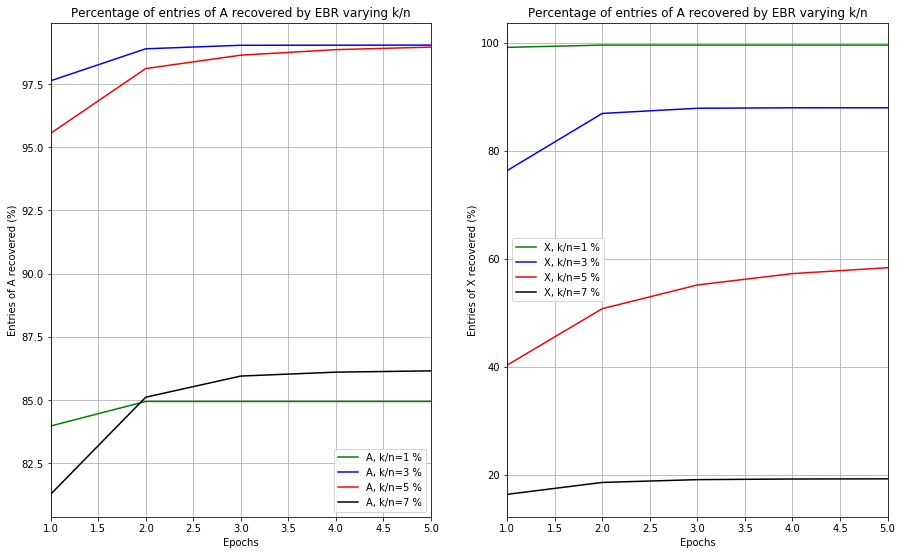

In [43]:
plt.figure(1).clear()

plot_A_entries = 100*A_entries/A_sparsity

plot_X_entries = np.zeros((len(k), max_epoch))
plot_frob = np.zeros((len(k), max_epoch))

for j in range(number_k_to_process):
    plot_X_entries[j,:] = 100*X_entries[j,:]/X_sparsity[j]
plot_epoch = 5

print("Running times:")
print("k/n=%s %%, %s s"%(100*k[0]/n, comp_time[0]))
print("k/n=%s %%, %s s"%(100*k[1]/n, comp_time[1]))      
print("k/n=%s %%, %s s"%(100*k[2]/n, comp_time[2]))  

plt.figure(1)
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.plot(np.arange(max_epoch)+1, plot_A_entries[0], 'g-', label="A, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[1], 'b-', label="A, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[2], 'r-', label="A, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[3], 'k-', label="A, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of A recovered by EBR varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of A recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.subplot(2,2,2)
plt.plot(np.arange(max_epoch)+1, plot_X_entries[0], 'g-',label="X, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[1], 'b-',label="X, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[2], 'r-',label="X, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[3], 'k-',label="X, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of A recovered by EBR varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of X recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
# plt.savefig('./figures_ACHA/EBR_performance.eps', format='eps', bbox_inches='tight')

## Running EBR-l0 to recover A and X varying $k/n$

In [59]:
# Extra parameters required for EBR-l0
alpha=3

# Run EBR interweaved with l-0 decode
if passed == True:
    eps = 1/6;
    max_epoch = 6
    tol = 10**-8
    comp_time_l0 = np.zeros(len(k))
    A_rec_l0 = np.zeros((len(k),m,n))
    X_rec_l0 = np.zeros((len(k),n,N))
    frob_error_series_l0 = np.ones((len(k), max_epoch))
    A_entries_l0 = np.zeros((len(k), max_epoch))
    X_entries_l0 = np.zeros((len(k), max_epoch))
    total_entries_l0 = np.zeros((len(k), max_epoch))   
    for j in range(number_k_to_process):
        print("Solving problem with k/n = ", str.format('{0:.1f}', 100*k[j]/n), '%, N = ', str.format('{0:.0f}', N))
        [A_rec_l0[j], X_rec_l0[j], frob_error_series_l0[j], total_entries_l0[j], A_entries_l0[j], X_entries_l0[j], comp_time_l0[j]] = EBR_l0(Y[j],N,m,n,d,k[j],eps,max_epoch,A_sparsity,X_sparsity[j],Y_frob[j],alpha)
        print("")
        P = check_recon_A(A, A_rec_l0[j],d,eps,n)
        print("")
        check_recon_X(X[j],X_rec_l0[j],P,N,k[j],n)
        print("")

Solving problem with k/n =  1.0 %, N =  200
Epoch  0  processed, l_2 error =  9.02 %, A l_0 error = 16.03 %, X l_0 error = 0.59 %.
Epoch  1  processed, l_2 error =  4.61 %, A l_0 error = 15.05 %, X l_0 error = 0.44 %.
No partial supports recovered, terminating algorithm

Checking reconstruction of A.
73.9 % of columns fully formed.
12.8 % of columns partially formed.
13.3 % of columns have no entries.
100.0 % of reconstructed (fully or partially) columns match with a column in target matrix.
15 % of entries missing in total.
679 entries missing in matched columns.
0 entries wrong in matched columns.

Checking the values of X recovered.
99.6 % of entries correctly recovered.
0.0 % of entries in correct location but have wrong value for location.
0.4 % of entries missing.

Solving problem with k/n =  3.0 %, N =  200
Epoch  0  processed, l_2 error =  11.72 %, A l_0 error = 2.37 %, X l_0 error = 13.16 %.
Epoch  1  processed, l_2 error =  1.88 %, A l_0 error = 0.90 %, X l_0 error = 11.88 %.

Running times:
k/n=1.0 %, 88.31737247 s
k/n=3.0 %, 432.382145961 s
k/n=5.0 %, 791.634413351 s


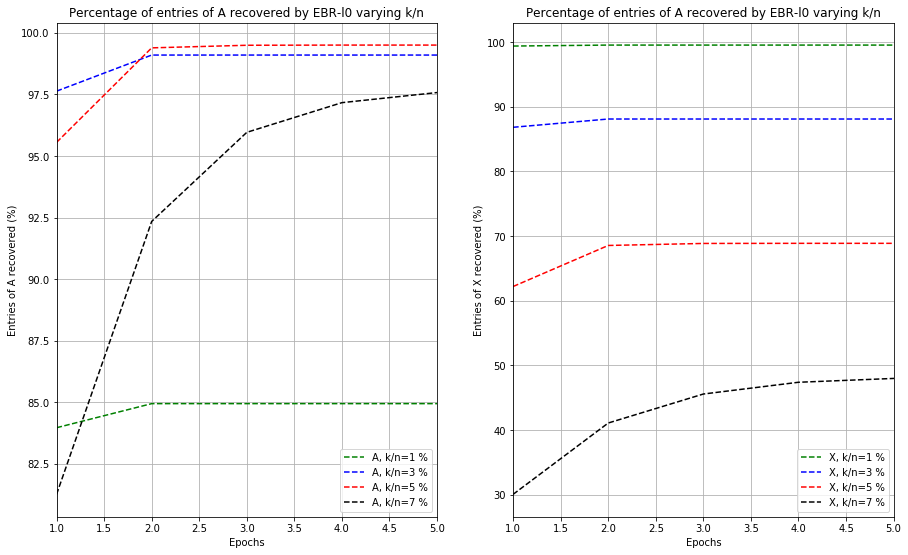

In [60]:
plt.figure(2).clear()

plot_X_entries_l0 = np.zeros((len(k), max_epoch))
plot_A_entries_l0 = 100*A_entries_l0/A_sparsity

for j in range(number_k_to_process):
    plot_X_entries_l0[j,:] = 100*X_entries_l0[j,:]/X_sparsity[j]

plot_epoch = 5

print("Running times:")
print("k/n=%s %%, %s s"%(100*k[0]/n, comp_time[0]))
print("k/n=%s %%, %s s"%(100*k[1]/n, comp_time[1]))      
print("k/n=%s %%, %s s"%(100*k[2]/n, comp_time[2]))  

plt.figure(2)
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[0], 'g--', label="A, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[1], 'b--', label="A, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[2], 'r--', label="A, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[3], 'k--', label="A, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of A recovered by EBR-l0 varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of A recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.subplot(2,2,2)
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[0], 'g--',label="X, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[1], 'b--',label="X, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[2], 'r--',label="X, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[3], 'k--',label="X, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of A recovered by EBR-l0 varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of X recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.savefig('./figures_ACHA/EBR_l0_performance.eps', format='eps', bbox_inches='tight')

## Side by side comparison of EBR vs EBR-l0

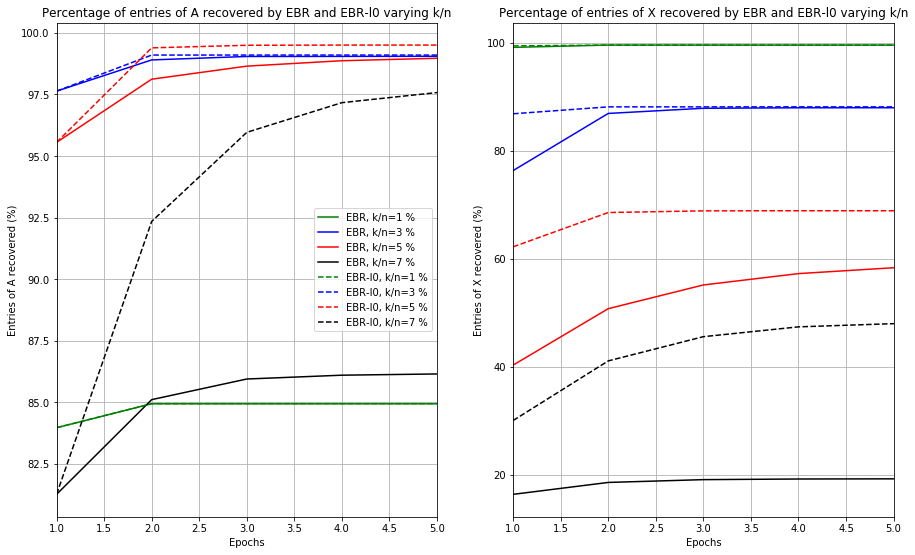

In [62]:
plt.figure(3)
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.plot(np.arange(max_epoch)+1, plot_A_entries[0], 'g-', label="EBR, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[1], 'b-', label="EBR, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[2], 'r-', label="EBR, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[3], 'k-', label="EBR, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[0], 'g--', label="EBR-l0, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[1], 'b--', label="EBR-l0, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[2], 'r--', label="EBR-l0, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[3], 'k--', label="EBR-l0, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of A recovered by EBR and EBR-l0 varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of A recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.subplot(2,2,2)
plt.plot(np.arange(max_epoch)+1, plot_X_entries[0], 'g-',label="EBR, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[1], 'b-',label="EBR, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[2], 'r-',label="EBR, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[3], 'k-',label="EBR, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[0], 'g--',label="EBR-l0, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[1], 'b--',label="EBR-l0, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[2], 'r--',label="EBR-l0, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[3], 'k--',label="EBR-l0, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of X recovered by EBR and EBR-l0 varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of X recovered (%)')
plt.xlim(1,plot_epoch)
# plt.legend()
plt.savefig('./figures_ACHA/EBR_vs_EBR_l0_comparison.eps', format='eps', bbox_inches='tight')